In [1]:
import torch
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from tqdm import tqdm


# Part 1

Define a simple NN model corresponding to a logistic regression model

In [2]:
def simple_nn(w1, w2, x1, x2):
    return 1./(1.+np.exp(-x1*w1 - x2*w2))


Generate data

In [3]:
#np.random.seed(42)
w_true = np.array([-1, 3])
X_data = 5 * np.random.rand(100, 2) - 2.5
y_prob = simple_nn(*w_true, X_data[:, 0], X_data[:, 1])
y_data = np.random.binomial(1, y_prob)


Data shapes

In [4]:
print(f'X_data shape {X_data.shape}')
print(f'y_data shape {y_data.shape}')


X_data shape (100, 2)
y_data shape (100,)


In [5]:
display(X_data[:10])


array([[ 1.61052357,  2.35936995],
       [-1.29027382,  1.32393728],
       [ 1.28395467, -2.18556316],
       [ 0.12112952, -2.36922896],
       [ 0.04923939, -2.22496912],
       [ 2.23742204, -1.57763544],
       [ 1.06347736, -0.42748765],
       [ 1.61789295,  1.60378301],
       [-1.49857942, -1.42077409],
       [ 0.03664948,  1.91253441]])

In [6]:
display(y_data[:10])


array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1])

Use the negative log-likelihood as loss function

In [7]:
@np.vectorize
def negloglik(w1, w2):
    return -1/y_data.shape[0] * (np.sum(np.log(simple_nn(w1, w2, X_data[y_data == 1, 0], X_data[y_data == 1, 1])))
                                 + np.sum(np.log(1.0 - simple_nn(w1, w2, X_data[y_data == 0, 0], X_data[y_data == 0, 1]))))


Do a bit of plotting of the error landscape

C:\Users\Vugs\AppData\Local\Temp\ipykernel_7904\3026449210.py:4: RuntimeWarning: divide by zero encountered in log
  + np.sum(np.log(1.0 - simple_nn(w1, w2, X_data[y_data == 0, 0], X_data[y_data == 0, 1]))))
c:\Users\Vugs\miniconda3\envs\p7\Lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


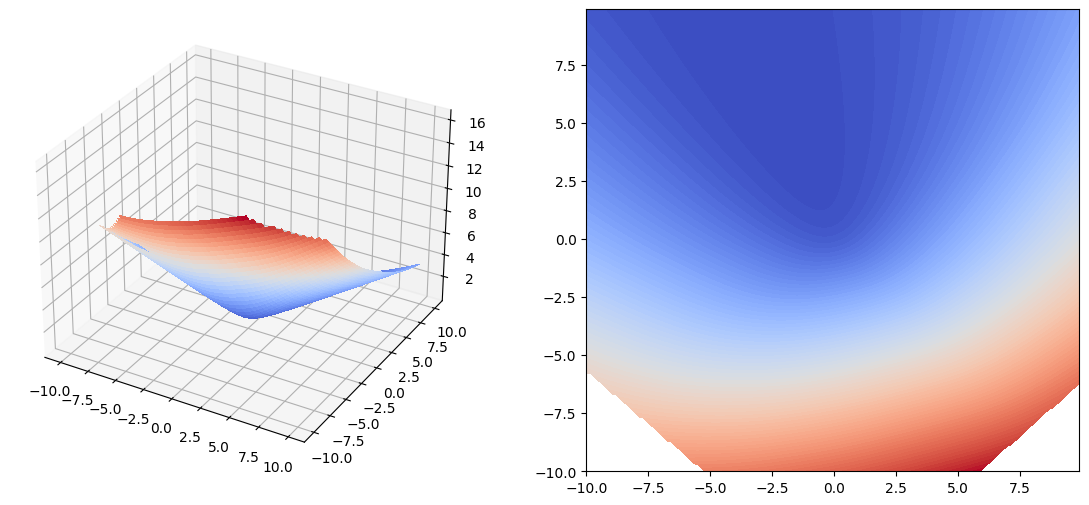

Negative log-lik for the true weights: 0.09008953731925129


In [8]:
delta = 0.1
x1 = np.arange(-10.0, 10.0, delta)
x2 = np.arange(-10.0, 10.0, delta)
# x1 = np.arange(0.5, 1.5, delta)
# x2 = np.arange(0.5, 1.5, delta)

X1, X2 = np.meshgrid(x1, x2)
Z = negloglik(X1, X2)

fig = plt.figure(figsize=(14, 6))

# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

ax = fig.add_subplot(1, 2, 2)
ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)

plt.show()

print(f'Negative log-lik for the true weights: {negloglik(*w_true)}')


## Exercise
1. Derive the gradient of the error function
2. Implement the gradient in the function below
3. Implement the gradient descent updating procedure. Experiment by changing the number of iterations, learning rate, amnd initialization point.

In [9]:
def gradient(w, X_train=X_data, y_train = y_data):
    return -1/y_train.shape[0] * np.array([np.sum((y_train - simple_nn(*w, X_train[:, 0], X_train[:, 1])) * X_train[:, 0]),
                                             np.sum((y_train - simple_nn(*w, X_train[:, 0], X_train[:, 1])) * X_train[:, 1])])


In [10]:
def gradient_descent(lr=0.1, epochs=100, init=np.array([0,0])):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    pbar = tqdm(range(epochs))
    for _ in pbar:
        w = w - lr * gradient(w)
        pbar.set_description(f'w = {w}')
        ax.scatter(*w, c='g')

    plt.show()
    return w


True weights: [-1  3]


w = [0.94767032 2.55419468]: 100%|██████████| 100/100 [00:00<00:00, 381.64it/s]


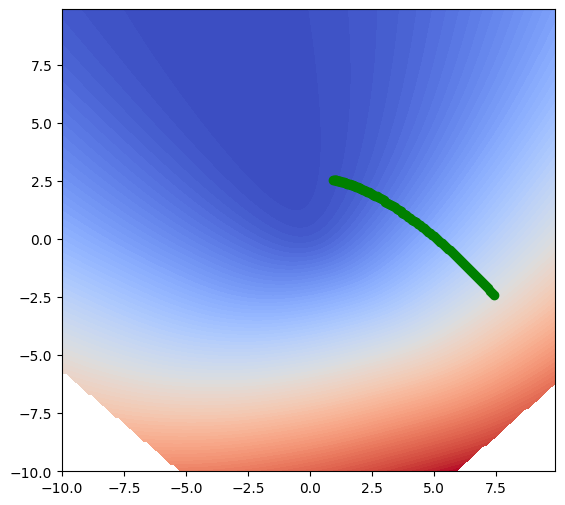

Found weights: [0.94767032 2.55419468]
NLL: 0.3319751288851217


In [11]:
w = gradient_descent(lr=0.1, init=np.array([7.5,-2.5]))
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')


# Part 2

Let's check the gradient calculations using PyTorch. For an introduction, see https://pytorch.org/tutorials/beginner/basics/intro.html. 

In [12]:
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()

x1 = torch.tensor(1.0, requires_grad=True)
w1 = torch.tensor(2.0, requires_grad=True)

x2 = torch.tensor(3.0, requires_grad=True)
w2 = torch.tensor(0.5, requires_grad=True)

y1 = x1*w1
y1.register_hook(lambda grad: print("Grad y1 = {}".format(grad)))

y2 = x2*w2
y2.register_hook(lambda grad: print("Grad y2 = {}".format(grad)))

y3 = y1+y2
y3.register_hook(lambda grad: print("Grad y3 = {}".format(grad)))

y4 = sigmoid(y3)
y4.register_hook(lambda grad: print("Grad y4 = {}".format(grad)))

y5 = relu(y3)
y5.register_hook(lambda grad: print("Grad y5 = {}".format(grad)))

y6 = y4 * y5
y6.register_hook(lambda grad: print("Grad y6 = {}".format(grad)))

e = (1.0 - y6)**2

e.backward()

print("Grad x1 = {}".format(x1.grad))
print("Grad x2 = {}".format(x2.grad))
print("Grad w1 = {}".format(w1.grad))
print("Grad w2 = {}".format(w2.grad))

print("Done")


Grad y6 = 4.794814109802246
Grad y5 = 4.654267311096191
Grad y4 = 16.781848907470703
Grad y3 = 5.1317620277404785
Grad y2 = 5.1317620277404785
Grad y1 = 5.1317620277404785
Grad x1 = 10.263524055480957
Grad x2 = 2.5658810138702393
Grad w1 = 5.1317620277404785
Grad w2 = 15.395286560058594
Done


# Part 4

Implement the following neural network with PyTorch (as above), where the hidden units and the output unit have a sigmoid activation function:

<img src="sigmoid-model.png" width="1000">

Let the loss function be $loss = (Y − O)^2$ and assume that we have the training example $(X = 1, O = 1)$.
1. Using your implementation, find the partial derivatives for each of the weights in the network.
2. How do the derivatives compare? Can you see a general pattern and what are the implications for gradient descent?
3. Can you argue for why you see this particular pattern? Hint: Consider the local contributions to the gradient from the sigmoid functions (what is the maximum value of the local gradient?).

In [13]:
sigmoid = torch.nn.Sigmoid()

x1 = torch.tensor(1.0, requires_grad=True)
w1 = torch.tensor(2.0, requires_grad=True)

y1 = sigmoid(x1*w1)
y1.register_hook(lambda grad: print("Grad y1 = {}".format(grad)))

y2 = sigmoid(y1)
y2.register_hook(lambda grad: print("Grad y2 = {}".format(grad)))

y3 = sigmoid(y2)
y3.register_hook(lambda grad: print("Grad y3 = {}".format(grad)))

y4 = sigmoid(y3)
y4.register_hook(lambda grad: print("Grad y4 = {}".format(grad)))

y5 = sigmoid(y4)
y5.register_hook(lambda grad: print("Grad y5 = {}".format(grad)))

y6 = sigmoid(y5)
y6.register_hook(lambda grad: print("Grad y6 = {}".format(grad)))

e = (1.0 - y6)**2

e.backward()

print("Grad x1 = {}".format(x1.grad))
print("Grad w1 = {}".format(w1.grad))

print("Done")


Grad y6 = -0.6816657781600952
Grad y5 = -0.15314701199531555
Grad y4 = -0.034386519342660904
Grad y3 = -0.007700376212596893
Grad y2 = -0.0017032461473718286
Grad y1 = -0.00035283801844343543
Grad x1 = -7.409148383885622e-05
Grad w1 = -3.704574191942811e-05
Done


# Part 4

## Exercise
1. Extend your implementation from Exercise 1 with momentum
2. Experiment by changing the number of iterations, learning rate, initialization point.

In [14]:
# Add momentum to the gradient descent
def gradient_descent(lr=0.1, epochs=300, init=np.array([0,0]), momentum=0.9):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    v = np.zeros_like(w)
    pbar = tqdm(range(epochs))
    for _ in pbar:
        v = momentum * v + lr * gradient(w)
        w = w - v
        pbar.set_description(f'w = {w}')
        ax.scatter(*w, c='g')

    plt.show()
    return w


True weights: [-1  3]


w = [0.22473178 3.59666634]:   0%|          | 0/300 [00:00<?, ?it/s]  

w = [-2.88775279  8.73930693]: 100%|██████████| 300/300 [00:00<00:00, 365.17it/s]


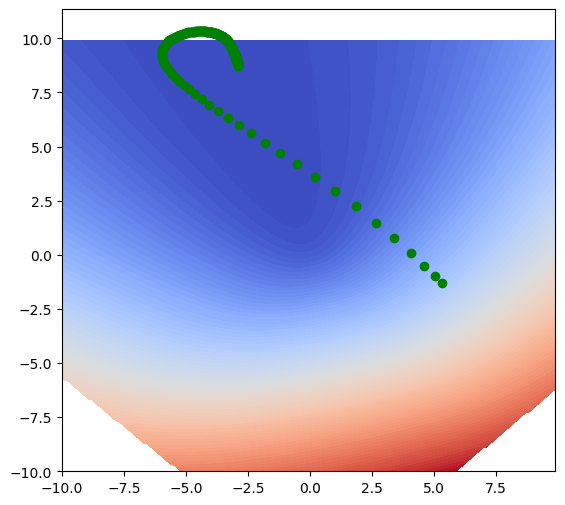

Found weights: [-2.88775279  8.73930693]
NLL: 0.0827028238381333


In [15]:
w = gradient_descent(lr=0.2, init=np.array([5.5,-1.5]))
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')


# Part 5

## Exercise
1. Implement stochastic gradient descent for the model in Exercise 1.
2. Experiment by changing the number of iterations, learning rate, initialization point, mini batch size.

In [16]:
def stochastic_gradient_descent(lr=0.1, epochs=100, init=np.array([0,0]), batch_size=10, momentum=0.7):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.contourf(X1, X2, Z, cmap=cm.coolwarm, levels=100)
    print(f'True weights: {w_true}')
    w = init
    v = np.zeros_like(w)
    idx = np.arange(X_data.shape[0])
    n_batches = len(idx) // batch_size
    pbar = tqdm(range(epochs))
    for _ in pbar:
        np.random.shuffle(idx)
        for b in range(n_batches):
            batch_idx = idx[b * batch_size:(b + 1) * batch_size]

            v = momentum * v + lr * gradient(w, X_train=X_data[batch_idx], y_train=y_data[batch_idx])
            w = w - v
            pbar.set_description(f'w = {w}')
            ax.scatter(*w, c='g')
    plt.show()
    return w


True weights: [-1  3]


  0%|          | 0/100 [00:00<?, ?it/s]

w = [-1.51826859  4.12517118]: 100%|██████████| 100/100 [00:00<00:00, 155.39it/s]


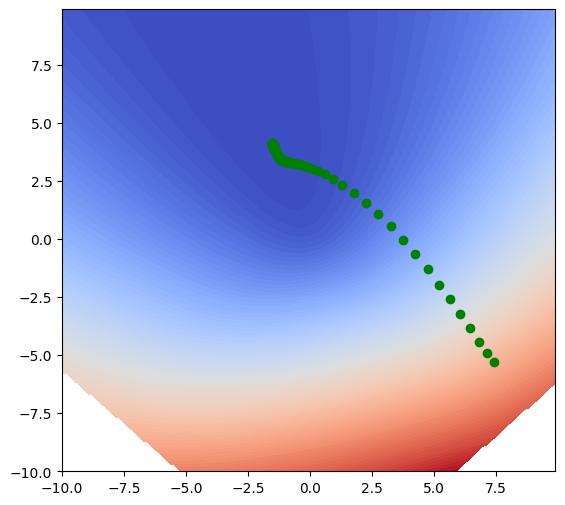

Found weights: [-1.51826859  4.12517118]
NLL: 0.07635336589771663


In [17]:
w = stochastic_gradient_descent(lr=0.2, init=np.array([7.5,-5.5]), batch_size=50)
print(f'Found weights: {w}')
print(f'NLL: {negloglik(*w)}')



# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [18]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np


Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [19]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 38084748.91it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29170514.36it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([128, 1, 28, 28])


Batch dimension (target): torch.Size([128])
Target: 6 with shape torch.Size([])


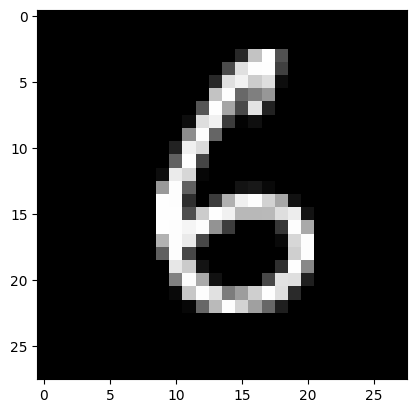

In [20]:
batch = next(iter(train_loader))
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")


With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [21]:
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


Out model specification

In [22]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb):
    return softmax(xb @ weights + bias)


Let's test our model (with our randomly initialized weights)

In [23]:
# We flatten the digit representation so that it is consistent with the weight matrix
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")


Batch shape: torch.Size([128, 784])
Prediction on first image tensor([0.1525, 0.1756, 0.0802, 0.1014, 0.1111, 0.0832, 0.0737, 0.0144, 0.1519,
        0.0560], grad_fn=<SelectBackward0>)
Corresponding classification: 1


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [24]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean()
loss_func = nll

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))


tensor(2.8839, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [25]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


In [26]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")


Accuracy of model on batch (with random weights): 0.078125


Now we are ready to combine it all and perform learning

In [27]:
epochs = 1  # how many epochs to train for
lr = 0.01  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        # We specify the loss
        loss = loss_func(pred, yb)
        # Add L2 Regularization
        l1_reg = 0.001
        loss += l1_reg + torch.sum(weights.abs())
        # and perform backpropagation
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # After updating we set the gradients to zero so that we ar eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()

            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)


Epoch: 0, B-idx: 0, Training loss: 2.5021589554703314
Epoch: 0, B-idx: 50, Training loss: 2.17258424647073
Epoch: 0, B-idx: 100, Training loss: 2.2023035183644244
Epoch: 0, B-idx: 150, Training loss: 2.218868294250228
Epoch: 0, B-idx: 200, Training loss: 2.1942010124100806
Epoch: 0, B-idx: 250, Training loss: 2.2078774356638697
Epoch: 0, B-idx: 300, Training loss: 2.1711482330680147
Epoch: 0, B-idx: 350, Training loss: 2.2192719689310234
Epoch: 0, B-idx: 400, Training loss: 2.2232605343434346
Epoch: 0, B-idx: 450, Training loss: 2.212975894972714


Plot the evolution of the training loss

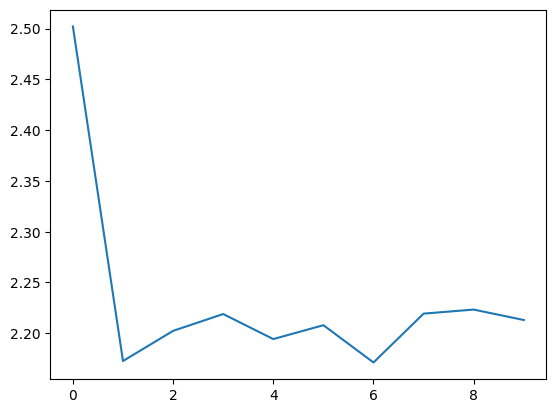

In [28]:
plt.plot(range(len(train_losses)), train_losses)


__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.
5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures. 